# Data flow

In the previous chapter we defined the control flow graph, in this chapter we will use the control flow graph in order to perform data flow analyses. We will consider four classical analyses (well known from compiler construction), as well as the data dependence graph.

As running example we will use the following function.

In [1]:
code = """
  public int foo(int x) {
    int y = 0;

    while(x >= 0) {
        int tmp = x;
        if(tmp % 2 == 0)
            y = x;
        x--;
    }

    return y;
  }
"""

## Control Flow Graph

The starting point for our dataflow analysis is the control flow graph, so we briefl redefine the CFG using the code from the last chapter.

In [2]:
import javalang

In [3]:
def parse_method(code):
    class_code = "class Dummy {\n" + code + "\n}";
    tokens = javalang.tokenizer.tokenize(class_code)
    parser = javalang.parser.Parser(tokens)
    ast = parser.parse()
    _, node = list(ast.filter(javalang.tree.MethodDeclaration))[0]
    return node

In [4]:
class CFGNode:
    def __init__(self, ast_node):
        self.ast_node = ast_node
    
    def __str__(self):
        if type(self.ast_node) == str:
            return self.ast_node
        else:
            return str(self.ast_node.position.line - 1)

In [5]:
import networkx as nx

In [6]:
class ProgramGraph:
    def __init__(self, graph, start, end):
        self.graph = graph
        self.start = start
        self.end   = end
        
    def nodes(self):
        return self.graph.nodes()
    
    def edges(self):
        return self.graph.edges()
    
    def successors(self, node):
        return self.graph.successors(node)
    
    def predecessors(self, node):
        return self.graph.predecessors(node)
    
    def is_branch(self, node):
        return self.graph.out_degree(node) > 1
    
    def is_merge(self, node):
        return self.graph.in_degree(node) > 1
    
    def plot(self):
        pos = nx.nx_agraph.graphviz_layout(self.graph, prog="dot")
        nx.draw_networkx_nodes(self.graph, pos=pos, node_size=800, node_color='#FFFFFF', edgecolors='#000000')
        nx.draw_networkx_edges(self.graph, pos=pos, connectionstyle="arc", arrowsize=20)
        nx.draw_networkx_labels(self.graph, pos=pos)
        nx.draw_networkx_edge_labels(self.graph, pos=pos, edge_labels=nx.get_edge_attributes(self.graph,'label'))

In [7]:
from functools import singledispatchmethod

In [8]:
class CFGBuilder:
    def __init__(self, method_declaration):
        # create graph
        self.graph = nx.DiGraph()
        
        # create entry/end node
        self.start = CFGNode("Start")
        self.end   = CFGNode("End")
        self.graph.add_node(self.start)
        self.graph.add_node(self.end)
        
        # set entry as current target
        self.frontier = [ self.start ]
        
        for node in method_declaration.body:
            self.add_node(node)
            
        # Add edges from last nodes to end node
        for parent in self.frontier:
            self.graph.add_edge(parent, self.end)

    def create_graph(self):
        return ProgramGraph(self.graph, self.start, self.end)
    
    @singledispatchmethod
    def add_node(self, node):
        pass
    
    @add_node.register        
    def add_block_node(self, block_node: javalang.tree.BlockStatement):
        for node in block_node.statements:
            self.add_node(node)            
    
    @add_node.register
    def add_statement_node(self, node: javalang.tree.StatementExpression):
        cfg_node = CFGNode(node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [ cfg_node ]
        
    @add_node.register
    def add_declaration_node(self, node: javalang.tree.LocalVariableDeclaration):
        self.add_statement_node(node)
        
    @add_node.register
    def add_if_node(self, if_node: javalang.tree.IfStatement):
        cfg_node = CFGNode(if_node)
        self.graph.add_node(cfg_node)

        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]
        self.add_node(if_node.then_statement)
        
        if if_node.else_statement:
            current_frontier = self.frontier[:]
            self.frontier = [cfg_node]
            self.add_node(if_node.else_statement)
            self.frontier.extend(current_frontier)
        else:
            self.frontier.append(cfg_node)
            
    @add_node.register
    def add_while_node(self, while_node: javalang.tree.WhileStatement):
        cfg_node = CFGNode(while_node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]
        self.add_node(while_node.body)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.frontier = [cfg_node]

    @add_node.register
    def add_return_node(self, return_node: javalang.tree.ReturnStatement):
        cfg_node = CFGNode(return_node)
        self.graph.add_node(cfg_node)
        for parent in self.frontier:
            self.graph.add_edge(parent, cfg_node)
        self.graph.add_edge(cfg_node, self.end)
        self.frontier = [] 

For the sake of completeness, here's the CFG of our example function.

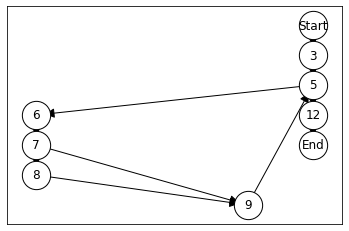

In [9]:
tree = parse_method(code)
cfg = CFGBuilder(tree).create_graph()
cfg.plot()

## Definitions and Uses

The central concept we are interested in during data flow analysis is where variables are assigned new values (i.e., where they are _defined_), and where these assigned values are read (i.e., where they are _used_). We can extract the information about available variables from the AST of a method.

In [10]:
def find_variables(method):
    variables = set()
    # Parameters
    for _, node in method.filter(javalang.tree.FormalParameter):
        variables.add(node.name)
        
    # Local variables
    for _, node in method.filter(javalang.tree.MemberReference):
        variables.add(node.member)
    
    # We ignore OOP stuff (attributes) for now
    return variables

Our example function defines three variables.

In [11]:
find_variables(tree)

{'tmp', 'x', 'y'}

Now we need to distinguish between where we _define_ and where we _use_ these variables. We can find the uses of variables by iterating over all `javalang.tree.MemberReference`s in the AST.

In [12]:
for _, node in tree.filter(javalang.tree.MemberReference):
    # TODO: Not on lhs of assignment
    print(f"Use of {node.member} in line {node.position.line - 1}")

Use of x in line 5
Use of x in line 6
Use of tmp in line 7
Use of y in line 8
Use of x in line 8
Use of x in line 9
Use of y in line 12


Variables are defined in local variable declarations, if they are used on the left hand side of an assignment, and when they are used with a prefix or postfix increment/decrement operator.

In [13]:
for _, node in tree.filter(javalang.tree.LocalVariableDeclaration):
    decl = node.declarators[0]
    print(f"Definition of {decl.name} in line {node.position.line - 1}")
for _, node in tree.filter(javalang.tree.Assignment):
    memberref = node.expressionl
    print(f"Definition of {memberref.member} in line {memberref.position.line - 1}")
for _, node in tree.filter(javalang.tree.MemberReference):
    if node.prefix_operators or node.postfix_operators:
        print(f"Definition of {node.member} in line {node.position.line - 1}")

Definition of y in line 3
Definition of tmp in line 6
Definition of y in line 8
Definition of x in line 9


We introduce a helper class to capture the information of a use; each Use stores the variable used, as well as the corresponding CFG node.

In [14]:
from dataclasses import dataclass

In [15]:
@dataclass(frozen=True, eq=True)
class Use:
    name: str
    node: CFGNode
        
    def __str__(self):
        if isinstance(self.node.ast_node, str):
            return f"Use: {self.name} in {self.node.ast_node}"
        
        return f"Use: {self.name} in line {self.node.ast_node.position.line - 1}"

Now we can extend our CFG with functionality to extract the uses for a given node.

In [16]:
class CFGNode(CFGNode):
    def uses(self):
        uses = set()
        if not self.ast_node or isinstance(self.ast_node, str):
            return uses
        
        # Do not check children that contain other statements
        root = self.ast_node
        if isinstance(self.ast_node, javalang.tree.ForStatement):
            root = self.ast_node.control
        elif hasattr(self.ast_node, "condition"):
            root = self.ast_node.condition
        elif isinstance(self.ast_node, javalang.tree.StatementExpression):
            # Assignment: lhs only if it is a +=, -=, etc
            if isinstance(self.ast_node.expression, javalang.tree.Assignment):
                if len(self.ast_node.expression.type) > 1:
                    root = self.ast_node.expression
                else:
                    root = self.ast_node.expression.value
            
        for _, node in root.filter(javalang.tree.MemberReference):
            uses.add(Use(node.member, self))
        for _, node in root.filter(javalang.tree.MethodInvocation):
            uses.add(Use(node.qualifier, self)) # Only works for non-static methods
        return uses

We have to re-create the CFG to sure our nodes have the new function.

In [17]:
cfg = CFGBuilder(tree).create_graph()

In [18]:
for node in cfg.nodes():
    use_str = ", ".join([str(use) for use in node.uses()])
    print(f"{node}: {use_str}")

Start: 
End: 
3: 
5: Use: x in line 5
6: Use: x in line 6
7: Use: tmp in line 7
8: Use: x in line 8
9: Use: x in line 9
12: Use: y in line 12


Now we do the same for definitions; we define a helper class, and then implement a function that extracts all definitions for a given CFG node.

In [19]:
@dataclass(frozen=True, eq=True)
class Definition:
    name: str
    node: CFGNode
        
    def __str__(self):
        return f"Def: {self.name} in line {self.node.ast_node.position.line - 1}"

In [20]:
class CFGNode(CFGNode):
    def definitions(self):
        definitions = set()
        if not self.ast_node or isinstance(self.ast_node, str):
            return definitions
        
        # Do not check children that contain other statements
        root = self.ast_node
        if isinstance(self.ast_node, javalang.tree.ForStatement):
            root = self.ast_node.control
        elif hasattr(self.ast_node, "condition"):
            root = self.ast_node.condition
                    
        for _, node in root.filter(javalang.tree.LocalVariableDeclaration):
            decl = node.declarators[0]
            definitions.add(Definition(decl.name, self))
        for _, node in root.filter(javalang.tree.Assignment):
            memberref = node.expressionl
            definitions.add(Definition(memberref.member, self))
        for _, node in root.filter(javalang.tree.MemberReference):
            if node.prefix_operators or node.postfix_operators:
                definitions.add(Definition(node.member, self))
        return definitions

In [21]:
class StartNode(CFGNode):
    def __init__(self, method_node):
        self.ast_node = method_node
        
    def definitions(self):
        definitions = set()
        
        for _, node in self.ast_node.filter(javalang.tree.FormalParameter):
            definitions.add(Definition(node.name, self))
        
        return definitions
        
    def __str__(self):
        return "Start"

In [22]:
class CFGBuilder(CFGBuilder):
    def __init__(self, method_declaration):
        # create graph
        self.graph = nx.DiGraph()
        
        # create entry/end node
        self.start = StartNode(method_declaration)
        self.end   = CFGNode("End")
        self.graph.add_node(self.start)
        self.graph.add_node(self.end)
        
        # set entry as current target
        self.frontier = [ self.start ]
        
        for node in method_declaration.body:
            self.add_node(node)
            
        # Add edges from last nodes to end node
        for parent in self.frontier:
            self.graph.add_edge(parent, self.end)

In [23]:
cfg = CFGBuilder(tree).create_graph()

In [24]:
for node in cfg.nodes():
    def_str = ", ".join([str(definition) for definition in node.definitions()])
    print(f"{node}: {def_str}")

Start: Def: x in line 2
End: 
3: Def: y in line 3
5: 
6: Def: tmp in line 6
7: 
8: Def: y in line 8
9: Def: x in line 9
12: 


## Dataflow Analysis

Given the information of which CFG node defines and uses which variables, the question now is how information flows across the program. Which definitions are matched with which of the uses? To determine this, we define a generic dataflow analysis framework.

In our dataflow analysis framework we distinguish between options for the analysis at hand:

- Are we interesed in where information flows to (forward analysis) or where it originates from (backward analysis)?
- Are we interested in things that _may_ happen or things that will always (_must_) happen?
- What is the information we are considering?
- How do individual nodes use/change this information?

### Join function

The join function helps us to distinguish between cases where we are interested in things that may happen, vs. things that will always happen.

May function: If fact exists in any of the incoming edges; implemented as set union.

In [25]:
def may(ts):
    result = set()
    for facts in ts:
        result = result.union(facts)
    return result

Must function: If fact exists in _all_ incoming edges; implemented as set intersection.

In [26]:
def must(ts):
    if not ts:
        return set()
    result = list(ts)[0]
    for facts in ts:
        result = result.intersection(facts)
    return result

Using an artificial example, assume we are trying to merge the following two sets of facts.

In [27]:
facts1 = {"x", "y"}
facts2 = {"y", "z"}

In [28]:
[facts1, facts2]

[{'x', 'y'}, {'y', 'z'}]

In [29]:
may([facts1, facts2])

{'x', 'y', 'z'}

In [30]:
must([facts1, facts2])

{'y'}

### Flow direction

The flow direction is used to control whether we are analysing where information propagates to, or where it originates from. The flow direction influences three aspects:
1. For a given node, what are the nodes from which information propagates from (in-nodes).
2. For a given node, what are the nodes that the dataflow information flows to (out-nodes).
3. What are the initial nodes to consider?

The last point is mainly an optimisation: If we consider backward flow, it is more efficient to iterate over the nodes in postorder (i.e., starting with nodes that are deep in the graph). If we consider forward flow, it is more efficient to iterate over the nodes in reverse postorder (i.e., starting with the first node). We extend our graph class to return nodes sorted in these two orders.

In [31]:
class ProgramGraph(ProgramGraph):
    def postorder(self):
        return list(nx.dfs_postorder_nodes(self.graph, self.start))
    
    def reverse_postorder(self):
        return self.postorder()[::-1]

In [32]:
cfg = CFGBuilder(tree).create_graph()

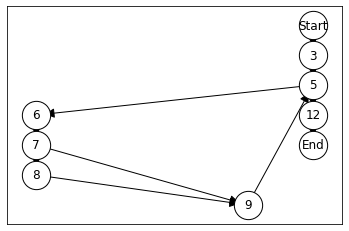

In [33]:
cfg.plot()

In [34]:
[str(node) for node in cfg.postorder()]

['9', '8', '7', '6', 'End', '12', '5', '3', 'Start']

In [35]:
[str(node) for node in cfg.reverse_postorder()]

['Start', '3', '5', '12', 'End', '6', '7', '8', '9']

Since each flow direction provides three different functions (in-nodes, out-nodes, and initial nodes) we define a simple class. Each of the three functionalities is implemented as a simple call to the underlying graph datastructure.

In [36]:
class ForwardFlowDirection:
    def in_nodes(self, cfg, node):
        return cfg.predecessors(node)
    
    def out_nodes(self, cfg, node):
        return cfg.successors(node)
    
    def initial_nodes(self, cfg):
        return cfg.reverse_postorder()

To allow us to query individual nodes of our CFG for examples, here is a helper function that returns the CFGNode for a given line number.

In [37]:
class ProgramGraph(ProgramGraph):
    def node_for_line(self, line_no):
        for node in self.nodes():
            if str(node) == str(line_no):
                return node
        return None

In [38]:
cfg = CFGBuilder(tree).create_graph()

In [39]:
node7 = cfg.node_for_line(7)

Line 7 has only one successor statement, line 6.

In [40]:
[str(x) for x in ForwardFlowDirection().in_nodes(cfg, node7)]

['6']

Since line 7 contains an if-statement, there are two outgoing edges.

In [41]:
[str(x) for x in ForwardFlowDirection().out_nodes(cfg, node7)]

['8', '9']

The initial nodes are defined in postorder, and will thus start with the `Start` node.

In [42]:
[str(x) for x in ForwardFlowDirection().initial_nodes(cfg)]

['Start', '3', '5', '12', 'End', '6', '7', '8', '9']

Backward flow is implemented similarly, and just needs to change which functions of our graph class are called.

In [43]:
class BackwardFlowDirection:
    def in_nodes(self, cfg, node):
        return cfg.successors(node)
    
    def out_nodes(self, cfg, node):
        return cfg.predecessors(node)
    
    def initial_nodes(self, cfg):
        return cfg.postorder()

When looking at the reverse control flow, line 7 has two input nodes.

In [44]:
[str(x) for x in BackwardFlowDirection().in_nodes(cfg, node7)]

['8', '9']

...and only one outgoing edge.

In [45]:
[str(x) for x in BackwardFlowDirection().out_nodes(cfg, node7)]

['6']

The order of nodes is reversed, such that the `Start` node will be last to consider.

In [46]:
[str(x) for x in BackwardFlowDirection().initial_nodes(cfg)]

['9', '8', '7', '6', 'End', '12', '5', '3', 'Start']

### Transfer function

The last puzzle piece before we can assemble our dataflow analysis is a transfer function, which decides which dataflow facts are _generated_ and _killed_ in each node. 

Since our main interest lies in finding out which definitions are matched with which uses, we start with the _reading definitions_ transfer function.

In [47]:
def reaching_definitions(node, in_facts):
    # (inFacts \ {kill}) ∪ {gen}
    result = set(in_facts)
    
    # Remove all definitions of variables that are defined here
    defined_vars = [definition.name for definition in node.definitions()]    
    result = { definition for definition in result if not definition.name in defined_vars }
    
    # Add new definitions of variables
    result = result.union(node.definitions())
    
    return result

In [48]:
node3 = cfg.node_for_line(3)
node6 = cfg.node_for_line(6)
node8 = cfg.node_for_line(8)

Line 3 defines the local variable `y`.

In [49]:
start_facts = node3.definitions()
[str(x) for x in start_facts]

['Def: y in line 3']

Suppose the information about this definition flows to line 6. Since line 6 does not overwrite `y` but defines `tmp`, the output of `reaching_definitions` will be two data flow facts.

In [50]:
[str(x) for x in reaching_definitions(node6, start_facts)]

['Def: y in line 3', 'Def: tmp in line 6']

In contrast, line 8 overwrites `y`. Thus, the output of `reaching_definitions` will only consist of the new definition of `y` and not the one from line 3.

In [51]:
[str(x) for x in reaching_definitions(node8, start_facts)]

['Def: y in line 8']

### Analysis framework

At this point we have all the ingredients to implement a dataflow analysis, and just need to combine them. We define a `DataFlowAnalysis` class for this purpose. This class keeps track of the CFG we are analyzing, the transfer function, flow direction, and join function used. The information produced by the dataflow analysis is stored in a dictionary `facts`, which should maintain the set of dataflow facts that holds at each node.

In [52]:
class DataFlowAnalysis:
    def __init__(self, cfg, transfer_function, flow_direction, join_function):
        self.cfg = cfg
        self.transfer_function = transfer_function
        self.flow_direction    = flow_direction
        self.join_function     = join_function
        
        self.facts = {}
        self.out_facts = {}
        
        for node in cfg.nodes():
            self.facts[node] = set()
            self.out_facts[node] = set()

In [53]:
class DataFlowAnalysis(DataFlowAnalysis):
    def initialize_must(self):
        all_facts = set()
        for node in self.cfg.nodes():
            facts |= transfer_function(node, set())
            
        for node in self.cfg.nodes():
            self.facts[node] = set(all_facts)
            self.out_facts[node] = set(all_facts)            

In [54]:
class DataFlowAnalysis(DataFlowAnalysis):
    def in_facts(self, node):
        in_nodes = self.flow_direction.in_nodes(self.cfg, node)
        facts = []
        for node in in_nodes:
            facts.append(self.out_facts[node])
            
        return self.join_function(facts)

In [55]:
analysis = DataFlowAnalysis(cfg, reaching_definitions, ForwardFlowDirection(), may)

In [56]:
analysis.in_facts(node8)

set()

The actual analysis consists of a fixpoint algorithm. The worklist is initialized depending on the flow direction. Then, for each node in the worklist we calculate the in-facts by applying the join function on all incoming edges. The in-facts are used to calculate the new out-facts. If the out-facts differ from the facts stored for a node, then all nodes the out-facts can flow to need to be updated and thus put on the worklist. Once the worklist is empty, a fixpoint has been reached.

In [57]:
class DataFlowAnalysis(DataFlowAnalysis):
    def apply(self):
        if self.transfer_function.__name__ == "must":
            self.initialize_must()
            
        worklist = self.flow_direction.initial_nodes(self.cfg)
        while worklist:
            node = worklist.pop()
            
            last_out = self.out_facts[node]
            in_facts = self.in_facts(node)
        
            self.facts[node] = in_facts
            new_out = self.transfer_function(node, in_facts)
            
            if last_out.symmetric_difference(new_out):
                self.out_facts[node] = new_out
                worklist.extend(self.flow_direction.out_nodes(self.cfg, node))

To determine which definition can reach which of the nodes, we can now construct a simple forward may dataflow analysis, using our `reaching_definitions` transfer function.

In [58]:
analysis = DataFlowAnalysis(cfg, reaching_definitions, ForwardFlowDirection(), may)

In [59]:
analysis.apply()

In [60]:
for node, defs in analysis.facts.items():
    defstr = [str(x) for x in defs]
    print(f"Node {node}: {defstr}")

Node Start: []
Node End: ['Def: x in line 9', 'Def: y in line 8', 'Def: y in line 3', 'Def: tmp in line 6', 'Def: x in line 2']
Node 3: ['Def: x in line 2']
Node 5: ['Def: x in line 9', 'Def: y in line 8', 'Def: y in line 3', 'Def: tmp in line 6', 'Def: x in line 2']
Node 6: ['Def: x in line 9', 'Def: y in line 8', 'Def: y in line 3', 'Def: tmp in line 6', 'Def: x in line 2']
Node 7: ['Def: x in line 9', 'Def: y in line 8', 'Def: y in line 3', 'Def: tmp in line 6', 'Def: x in line 2']
Node 8: ['Def: x in line 9', 'Def: y in line 8', 'Def: y in line 3', 'Def: tmp in line 6', 'Def: x in line 2']
Node 9: ['Def: x in line 9', 'Def: y in line 3', 'Def: x in line 2', 'Def: y in line 8', 'Def: tmp in line 6']
Node 12: ['Def: x in line 9', 'Def: y in line 8', 'Def: y in line 3', 'Def: tmp in line 6', 'Def: x in line 2']


For reference, here is the code we are considering.

In [61]:
for i, line in enumerate(code.split('\n')):
    print(str(i + 1).rjust(3, ' '), ':', line)

  1 : 
  2 :   public int foo(int x) {
  3 :     int y = 0;
  4 : 
  5 :     while(x >= 0) {
  6 :         int tmp = x;
  7 :         if(tmp % 2 == 0)
  8 :             y = x;
  9 :         x--;
 10 :     }
 11 : 
 12 :     return y;
 13 :   }
 14 : 


Let's look at another example.

In [62]:
code2 = """
public String badCode(int x) {
    String y = null;
    if (x > 0) {
        y = "more";
    } else if (x < 0) {
        y = "less";
    }
    return y.toUpperCase();
}
"""

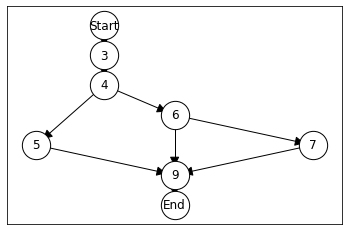

In [63]:
tree2 = parse_method(code2)
cfg2 = CFGBuilder(tree2).create_graph()
cfg2.plot()

In [64]:
analysis2 = DataFlowAnalysis(cfg2, reaching_definitions, ForwardFlowDirection(), may)

In [65]:
analysis2.apply()

In [66]:
for node, defs in analysis2.facts.items():
    defstr = [str(x) for x in defs]
    print(f"Node {node}: {defstr}")

Node Start: []
Node End: ['Def: x in line 2', 'Def: y in line 7', 'Def: y in line 5', 'Def: y in line 3']
Node 3: ['Def: x in line 2']
Node 4: ['Def: x in line 2', 'Def: y in line 3']
Node 5: ['Def: x in line 2', 'Def: y in line 3']
Node 6: ['Def: x in line 2', 'Def: y in line 3']
Node 7: ['Def: x in line 2', 'Def: y in line 3']
Node 9: ['Def: x in line 2', 'Def: y in line 5', 'Def: y in line 3', 'Def: y in line 7']


### Liveness Analysis

Liveness is an example of a backwards may analysis: Liveness checks for each variable $v$ at program point $p$ if 
$v$ will be used on some execution path originating from $p$ before $v$ is overwritten. This is useful for optimisation (if variable is dead at assignment, we can eliminate the assignment) as well as for detecting errors (no variable should be live at program entry point).

In [67]:
def liveness(node, in_facts):

    # gen ∪ (inFacts \ kill) 
    result = set(in_facts)
    
    # Remove all expressions of variables that are defined here
    defined_vars = [definition.name for definition in node.definitions()]
    result = { use for use in result if not use.name in defined_vars }

    # Add new uses
    result = result.union(set(node.uses()))
    
    return result

In [68]:
analysis = DataFlowAnalysis(cfg, liveness, BackwardFlowDirection(), may)

In [69]:
analysis.apply()

In [70]:
for node, defs in analysis.facts.items():
    defstr = [str(x) for x in defs]
    print(f"Node {node}: {defstr}")

Node Start: ['Use: x in line 8', 'Use: x in line 9', 'Use: x in line 6', 'Use: x in line 5']
Node End: []
Node 3: ['Use: x in line 5', 'Use: x in line 9', 'Use: x in line 6', 'Use: x in line 8', 'Use: y in line 12']
Node 5: ['Use: x in line 9', 'Use: x in line 6', 'Use: x in line 8', 'Use: y in line 12']
Node 6: ['Use: x in line 8', 'Use: x in line 9', 'Use: tmp in line 7', 'Use: y in line 12']
Node 7: ['Use: x in line 8', 'Use: x in line 9', 'Use: y in line 12']
Node 8: ['Use: y in line 12', 'Use: x in line 9']
Node 9: ['Use: x in line 5', 'Use: x in line 9', 'Use: x in line 6', 'Use: x in line 8', 'Use: y in line 12']
Node 12: []


In [71]:
for i, line in enumerate(code.split('\n')):
    print(str(i + 1).rjust(3, ' '), ':', line)

  1 : 
  2 :   public int foo(int x) {
  3 :     int y = 0;
  4 : 
  5 :     while(x >= 0) {
  6 :         int tmp = x;
  7 :         if(tmp % 2 == 0)
  8 :             y = x;
  9 :         x--;
 10 :     }
 11 : 
 12 :     return y;
 13 :   }
 14 : 


In [72]:
analysis2 = DataFlowAnalysis(cfg2, liveness, BackwardFlowDirection(), may)

In [73]:
analysis2.apply()

In [74]:
for node, defs in analysis2.facts.items():
    defstr = [str(x) for x in defs]
    print(f"Node {node}: {defstr}")

Node Start: ['Use: x in line 4', 'Use: x in line 6']
Node End: []
Node 3: ['Use: y in line 9', 'Use: x in line 6', 'Use: x in line 4']
Node 4: ['Use: y in line 9', 'Use: x in line 6']
Node 5: ['Use: y in line 9']
Node 6: ['Use: y in line 9']
Node 7: ['Use: y in line 9']
Node 9: []


In [75]:
for i, line in enumerate(code2.split('\n')):
    print(str(i + 1).rjust(3, ' '), ':', line)

  1 : 
  2 : public String badCode(int x) {
  3 :     String y = null;
  4 :     if (x > 0) {
  5 :         y = "more";
  6 :     } else if (x < 0) {
  7 :         y = "less";
  8 :     }
  9 :     return y.toUpperCase();
 10 : }
 11 : 


### Available Expressions

To complete our set of example dataflow analyses, we also consider forward and backward _must_-analysis. We will use the classical examples from compiler construction for this, and the example for a forward-must analysis is the _available expressions_ analysis.

An expression $e$ is available at program point $p$ if $e$ is computed on every path to $p$, and the value of $e$ has not changed since the last time $e$ is computed on $p$. This is useful for example in compiler optimisation: If an expression is available, it does not need to be recomputed.

We will only focus on binary operations as example expressions. So far, the dataflow facts of our analyses were definitions and uses, now we need to introduce a new type of dataflow fact -- expressions. We define a helper function that returns all children in an AST that are not statements (i.e., it is an iterator giving us statement trees).

In [76]:
def get_children(root):
    children = None

    if isinstance(root, javalang.tree.Node):
        yield root
        children = root.children
    else:
        children = root

    for child in children:
        if isinstance(child, javalang.tree.Statement):
            continue
    
        if isinstance(child, (javalang.tree.Node, list, tuple)):
            for node in get_children(child):
                yield node

Using this function, we can extract expressions by retrieving all binary operators for each CFG node.

In [77]:
for cfgnode in cfg.nodes():
    if not isinstance(cfgnode.ast_node, str):
        for node in get_children(cfgnode.ast_node):
            if isinstance(node, javalang.tree.BinaryOperation):
                print(f"Expression of {node.operandl} {node.operator} {node.operandr} at line {cfgnode.ast_node.position.line}")

Expression of MemberReference(member=x, postfix_operators=[], prefix_operators=[], qualifier=, selectors=[]) >= Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=0) at line 6
Expression of BinaryOperation(operandl=MemberReference(member=tmp, postfix_operators=[], prefix_operators=[], qualifier=, selectors=[]), operandr=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=2), operator=%) == Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=0) at line 8
Expression of MemberReference(member=tmp, postfix_operators=[], prefix_operators=[], qualifier=, selectors=[]) % Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=2) at line 8


The previous analyses used definitions and uses as dataflow facts, so now we require a helper class that captures what an expression is for our dataflow facts. An expression can refer to multiple variables, so determining this set is slightly more code than on definitions and uses.

In [78]:
@dataclass(frozen=True, eq=True)
class Expression:
    expression: javalang.tree.BinaryOperation
    node: CFGNode

    def variables(self):
        variables = set()
        if not self.expression or isinstance(self.expression, str):
            return variables
        
        # Do not check children that contain other statements
        root = self.expression
        if isinstance(self.expression, javalang.tree.ForStatement):
            root = self.expression.control
        elif hasattr(self.expression, "condition"):
            root = self.expression.condition
        elif isinstance(self.expression, javalang.tree.StatementExpression):
            # Assignment: lhs only if it is a +=, -=, etc
            if isinstance(self.expression.expression, javalang.tree.Assignment):
                if len(self.expression.expression.type) > 1:
                    root = self.expression.expression
                else:
                    root = self.expression.expression.value
            
        for _, node in root.filter(javalang.tree.MemberReference):
            variables.add(node.member)
        return variables
    
    def __str__(self):
        return f"Expression: {self.expression} in line {self.node.ast_node.position.line - 1}"

Similar to how we extracted definitions and uses from nodes using the _nodes_ and _definitions_ methods (which would be the gen-sets in the literature), we also define a function that extracts expressions from nodes. 

In [79]:
class CFGNode(CFGNode):
    def expressions(self):
        expressions = set()
        if not self.ast_node or isinstance(self.ast_node, str):
            return expressions
        
        for node in get_children(self.ast_node):
            if isinstance(node, javalang.tree.BinaryOperation):
                expressions.add(Expression(node, self))
                
        return expressions

Since we defined an extra class for the start node, we also need to override the method there.

In [80]:
class StartNode(StartNode):
    def expressions(self):
        return set()

Given all these changes, we need to recreate the CFG.

In [81]:
cfg = CFGBuilder(tree).create_graph()

In [82]:
node7 = cfg.node_for_line(7)

In [83]:
node7.expressions()

{Expression(expression=BinaryOperation(operandl=BinaryOperation(operandl=MemberReference(member=tmp, postfix_operators=[], prefix_operators=[], qualifier=, selectors=[]), operandr=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=2), operator=%), operandr=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=0), operator===), node=<__main__.CFGNode object at 0x10ceaaee0>),
 Expression(expression=BinaryOperation(operandl=MemberReference(member=tmp, postfix_operators=[], prefix_operators=[], qualifier=, selectors=[]), operandr=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=2), operator=%), node=<__main__.CFGNode object at 0x10ceaaee0>)}

The transfer function is simple: Given the in-set, all expressions for which the variables are defined in a node are killed, and all expressions that are generated are added.

In [84]:
def available_expressions(node, in_facts):
    # gen ∪ (inFacts \ kill) 
    result = set(in_facts)
    
    # kill = remove all expressions for which a variable is defined here
    # gen  = new_expressions
    
    # Remove all expressions of variables that are defined here
    defined_vars = set([definition.name for definition in node.definitions()])
    
    result = { expression for expression in result if not defined_vars.symmetric_difference(set(expression.variables())) }
    
    # Add new expressions
    result = result.union(set(node.expressions()))
    
    return result

We can thus create our forward-must dataflow analysis.

In [85]:
analysis = DataFlowAnalysis(cfg, available_expressions, ForwardFlowDirection(), must)

In [86]:
analysis.apply()

In [87]:
for node, defs in analysis.facts.items():
    defstr = [str(x) for x in defs]
    print(f"Node {node}: {defstr}")

Node Start: []
Node End: []
Node 3: []
Node 5: []
Node 6: ['Expression: BinaryOperation(operandl=MemberReference(member=x, postfix_operators=[], prefix_operators=[], qualifier=, selectors=[]), operandr=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=0), operator=>=) in line 5']
Node 7: []
Node 8: ['Expression: BinaryOperation(operandl=MemberReference(member=tmp, postfix_operators=[], prefix_operators=[], qualifier=, selectors=[]), operandr=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=2), operator=%) in line 7', 'Expression: BinaryOperation(operandl=BinaryOperation(operandl=MemberReference(member=tmp, postfix_operators=[], prefix_operators=[], qualifier=, selectors=[]), operandr=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=2), operator=%), operandr=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=0), operator===) in line 7']
Nod

In [88]:
for i, line in enumerate(code.split('\n')):
    print(str(i + 1).rjust(3, ' '), ':', line)

  1 : 
  2 :   public int foo(int x) {
  3 :     int y = 0;
  4 : 
  5 :     while(x >= 0) {
  6 :         int tmp = x;
  7 :         if(tmp % 2 == 0)
  8 :             y = x;
  9 :         x--;
 10 :     }
 11 : 
 12 :     return y;
 13 :   }
 14 : 


### Very Busy Expressions

An expression $e$ is very busy at point $p$ if on every path from $p$, expression $e$ is evaluated before the value of $e$ is changed. This is, for example, useful for optimisations, since very busy expression computations can be hoisted. Very busy expressions is a backward-must analysis.

The dataflow facts for this analysis are expressions, so we only need to define the transfer function -- which is identical to live expressions.

In [89]:
def very_busy_expressions(node, in_facts):
    # An expression e is very busy at point p if
    # On every path from p, expression e is evaluated before the value of e is changed
        
    # gen ∪ (inFacts \ kill) 
    result = set(in_facts)
    
    # Remove all expressions of variables that are defined here
    defined_vars = set([definition.name for definition in node.definitions()])    
    result = { expression for expression in result if not defined_vars.symmetric_difference(set(expression.variables())) }
    
    # Add new expressions
    result = result.union(set(node.expressions()))
    
    return result

In [90]:
analysis = DataFlowAnalysis(cfg, very_busy_expressions, BackwardFlowDirection(), must)

In [91]:
analysis.apply()

In [92]:
for node, defs in analysis.facts.items():
    defstr = [str(x) for x in defs]
    print(f"Node {node}: {defstr}")

Node Start: []
Node End: []
Node 3: ['Expression: BinaryOperation(operandl=MemberReference(member=x, postfix_operators=[], prefix_operators=[], qualifier=, selectors=[]), operandr=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=0), operator=>=) in line 5']
Node 5: []
Node 6: ['Expression: BinaryOperation(operandl=MemberReference(member=tmp, postfix_operators=[], prefix_operators=[], qualifier=, selectors=[]), operandr=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=2), operator=%) in line 7', 'Expression: BinaryOperation(operandl=BinaryOperation(operandl=MemberReference(member=tmp, postfix_operators=[], prefix_operators=[], qualifier=, selectors=[]), operandr=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=2), operator=%), operandr=Literal(postfix_operators=[], prefix_operators=[], qualifier=None, selectors=[], value=0), operator===) in line 7']
Node 7: []
Node 8: ['Expr

In [93]:
for i, line in enumerate(code.split('\n')):
    print(str(i + 1).rjust(3, ' '), ':', line)

  1 : 
  2 :   public int foo(int x) {
  3 :     int y = 0;
  4 : 
  5 :     while(x >= 0) {
  6 :         int tmp = x;
  7 :         if(tmp % 2 == 0)
  8 :             y = x;
  9 :         x--;
 10 :     }
 11 : 
 12 :     return y;
 13 :   }
 14 : 


## Data Dependence Graph

Now that we know how to determine dataflow information, we can finally look at how to create a data dependence graph (DDG): The DDG consists of the same nodes as the CFG, but contains edges for all definition-use pairs. To generate the DDG, we thus iterate over all nodes; for each use in a node, we iterate over all reaching definitions that match the same variable, and add an edge.

In [94]:
def create_ddg(cfg):
    analysis = DataFlowAnalysis(cfg, reaching_definitions, ForwardFlowDirection(), may)
    analysis.apply()
    
    # Create unconnected graph
    ddg = nx.DiGraph()
    ddg.add_nodes_from(cfg.nodes())
    
    # Add dataflow edges
    for node in cfg.nodes():
        for use in node.uses():
            for definition in analysis.facts[node]:
                if use.name == definition.name:
                    # add edge from the definition node to use node
                    ddg.add_edge(definition.node, node, label=use.name)
            
    return ProgramGraph(ddg, cfg.start, cfg.end)

In [95]:
for i, line in enumerate(code.split('\n')):
    print(str(i + 1).rjust(3, ' '), ':', line)

  1 : 
  2 :   public int foo(int x) {
  3 :     int y = 0;
  4 : 
  5 :     while(x >= 0) {
  6 :         int tmp = x;
  7 :         if(tmp % 2 == 0)
  8 :             y = x;
  9 :         x--;
 10 :     }
 11 : 
 12 :     return y;
 13 :   }
 14 : 


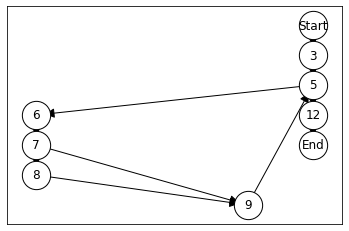

In [96]:
cfg.plot()

In [97]:
for i, line in enumerate(code.split('\n')):
    print(str(i + 1).rjust(3, ' '), ':', line)

  1 : 
  2 :   public int foo(int x) {
  3 :     int y = 0;
  4 : 
  5 :     while(x >= 0) {
  6 :         int tmp = x;
  7 :         if(tmp % 2 == 0)
  8 :             y = x;
  9 :         x--;
 10 :     }
 11 : 
 12 :     return y;
 13 :   }
 14 : 


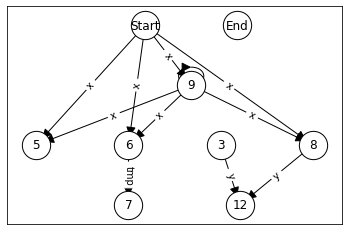

In [98]:
dfg = create_ddg(cfg)
dfg.plot()

In [99]:
for i, line in enumerate(code2.split('\n')):
    print(str(i + 1).rjust(3, ' '), ':', line)

  1 : 
  2 : public String badCode(int x) {
  3 :     String y = null;
  4 :     if (x > 0) {
  5 :         y = "more";
  6 :     } else if (x < 0) {
  7 :         y = "less";
  8 :     }
  9 :     return y.toUpperCase();
 10 : }
 11 : 


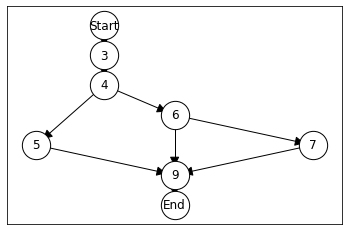

In [100]:
cfg2.plot()

In [101]:
for i, line in enumerate(code2.split('\n')):
    print(str(i + 1).rjust(3, ' '), ':', line)

  1 : 
  2 : public String badCode(int x) {
  3 :     String y = null;
  4 :     if (x > 0) {
  5 :         y = "more";
  6 :     } else if (x < 0) {
  7 :         y = "less";
  8 :     }
  9 :     return y.toUpperCase();
 10 : }
 11 : 


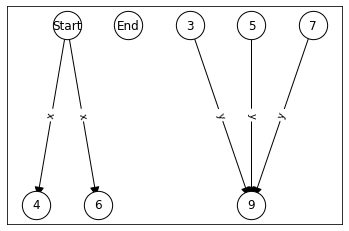

In [102]:
dfg2 = create_ddg(cfg2)
dfg2.plot()